# Evaluating ability to account for other machines

Notebook to investigate the ability to use predictions from the CNN and to feed them into a secondary model to predict other machine pull times.

In [1]:
import os
import time

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.data.config import load_config
from optpresso.data.partition import find_test_paths
from optpresso.models.serialization import load_model

from IPython.core.display import display

In [2]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Path to alternative machine data
DATA_DIR = os.path.expanduser("~/breville/")
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv&gid=1013114014"
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
config = load_config()
if config is None:
    print("Invalid config, call optpresso init")
    raise ValueError("Invalid config")
model_path = config.model
model = load_model(model_path, compile=False)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)
for key in images_by_time.keys():
    images_by_time[key].sort()

In [3]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

### A bit of hacky code to associate CSV data with the relevant file paths

Relies on the fact that there are gaps in time between each set of images. Helped by the data is consistently
collected in this case, the training data doesn't work with the same procedure.

In [4]:

def cluster(clusters: int, paths: List[str]) -> Tuple[List[str], List[str]]:
    timestamps = np.zeros(len(paths), dtype=np.int32)
    deltas = np.zeros(len(paths) - 1, dtype=np.int32)
    for i, path in enumerate(paths):
        pull_time = int(os.path.basename(os.path.dirname(path)))
        timestamp = os.path.basename(path).split("-")[0]
        if not timestamp.isdigit():
            raise RuntimeError(f"{path} doesn't start with timestamp!")
        timestamps[i] = int(timestamp)
        if i > 0:
            deltas[i-1] = np.abs(timestamps[i-1] - timestamps[i])
    sort = np.argsort(deltas)[::-1] # Descending order
    # Get one less indice to split, to create N chunks
    indices_to_split = sort[:clusters-1].tolist()
    idx = 0
    cluster_groups = []
    for i in range(len(paths)):
        if i == 0:
            cluster_groups.append(idx)
            continue
        if i - 1 in indices_to_split:
            idx += 1
        cluster_groups.append(idx)
        
    return np.asarray(cluster_groups, dtype=np.int32)

all_paths = []
for pull, paths in images_by_time.items():
    all_paths.extend(paths)
clustered = cluster(len(df), all_paths)
chunks = defaultdict(list)
for pull, paths in images_by_time.items():
    sub_df = df[df.timeseconds == pull]
    last_time = None
    groups = cluster(len(sub_df), paths)
    for group in set(groups):
        relevant_paths = [x for x in np.where(groups == group, paths, None) if x is not None]
        series_time = None
        for path in relevant_paths:
            pull_time = os.path.basename(os.path.dirname(path))
            if not pull_time.isdigit():
                raise ValueError("Invalid {}".format(relevant_paths))
            pull_time = int(pull_time)
            if series_time is None:
                series_time = pull_time
            elif series_time != pull_time:
                raise ValueError("Got multiple pull times! {}".format(relevant_paths))
        chunks[series_time].append(relevant_paths)

last_index_per_time = defaultdict(int)
predictions = []
for row in df.values:
    pull_time = row[2]
    chunk_idx = last_index_per_time[pull_time]
    loader = GroundsLoader(min(256, len(chunks[pull_time][chunk_idx])), (model.input_shape[1], model.input_shape[2]), paths=chunks[pull_time][chunk_idx])
    predictions.append(model.predict(loader.get_batch(0, len(loader))[0]).squeeze())
    last_index_per_time[pull_time] += 1
for pull, idx in last_index_per_time.items():
    if len(chunks[pull]) != idx:
        raise ValueError(f"Didn't consume all chunks: {pull} has {len(chunks[pull])}, and only used {idx}")
df["predictions"] = predictions

In [5]:
df = df[df["grinder"] != "Vario-W"] # Need to munge the grind settings into a series
df = df.astype({'grindsetting': 'int32'})

In [6]:
# Do an 80:20 cross validation split
train = df.sample(frac=0.8, random_state=618)
test = df.drop(train.index)

In [7]:
train

,ingrams,outgrams,timeseconds,coffee,grinder,machine,grindsetting,ratio,predictions
11,16.9,54.8,23,Candlestick - Columbia,Breville,Breville Barista Express,7,3.24,"[15.224821, 14.905588, 18.195332, 15.2738495, ..."
4,16.4,47.0,39,Candlestick - Columbia,Breville,Breville Barista Express,3,2.87,"[14.423201, 15.731222, 17.821096, 15.830266, 1..."
9,14.6,58.5,21,Candlestick - Columbia,Breville,Breville Barista Express,6,4.01,"[10.649885, 11.165432, 10.929792, 14.471729, 8..."
5,16.0,50.0,29,Candlestick - Columbia,Breville,Breville Barista Express,5,3.13,"[14.943422, 11.233141, 16.862366, 14.196299, 1..."
22,14.6,54.2,18,Candlestick - Columbia,Breville,Breville Barista Express,10,3.71,"[13.082521, 12.152578, 13.258688, 13.800398, 1..."
14,16.0,61.2,21,Candlestick - Columbia,Breville,Breville Barista Express,8,3.83,"[16.176594, 15.943863, 15.688328, 17.174238, 1..."
34,13.0,36.0,29,Coava - Ethiopia Kilenso Natural Heirloom,Niche Zero,Illy Francis Francis,7,2.77,"[37.15548, 37.823574, 35.098854, 33.652863, 35..."
3,17.1,49.3,36,Candlestick - Columbia,Breville,Breville Barista Express,3,2.88,"[16.111868, 18.235634, 15.151438, 14.0595875, ..."
8,15.8,57.1,22,Candlestick - Columbia,Breville,Breville Barista Express,6,3.61,"[10.262215, 13.988012, 10.055014, 14.265192, 9..."
23,10.4,67.5,23,Candlestick - Columbia,Breville,Breville Barista Express,10,6.49,"[14.950224, 11.997953, 14.137665, 12.786879, 1..."


## Evaluate using Gaussian Process to make predictions

It is feasible to build a personalized Gaussian Process (GP) model, and this is to do a basic proof of concept to see if it isn't totally worthless.

With Dropped columns: ('outgrams',)
Average Error 5.934371625983872


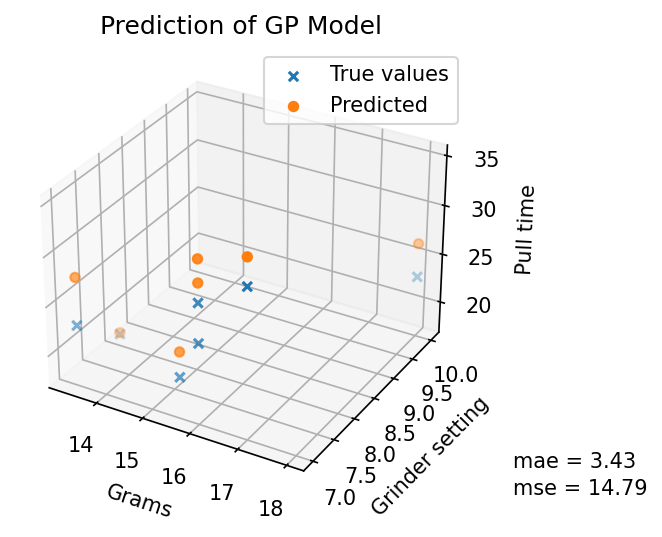

With Dropped columns: ('ratio', 'outgrams')
Average Error 5.932667702590673


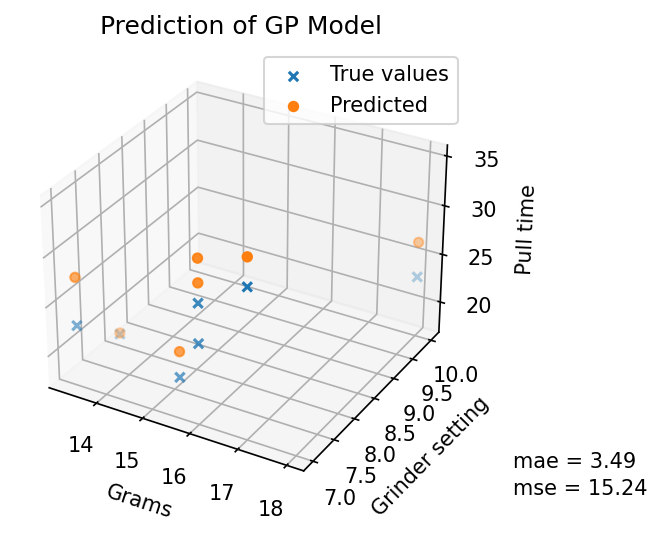

Best Column combination ['coffee', 'grinder', 'grindsetting', 'ingrams', 'machine', 'predictions', 'ratio']


In [8]:
def prepare_df_for_gp(frame, prediction_column="timeseconds", encoded_cols=("grinder", "coffee", "machine"), drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        new_frame = new_frame.drop([col], axis=1)
    for col in encoded_cols:
        if col not in new_frame:
            print("No such column:", col)
            continue
        encoder = OneHotEncoder(handle_unknown="ignore")
        new_frame[col] = encoder.fit_transform(np.asarray(new_frame[col]).reshape(-1, 1)).toarray()
    
    y = np.asarray(new_frame[prediction_column])
    new_frame = new_frame.drop([prediction_column], axis=1)
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    col_idxs = {}
    for i in range(len(new_frame)):
        for j, col in enumerate(sorted(new_frame.columns)):
            col_idxs[col] = j
            vals = np.asarray(new_frame[col].values[i])
            if isinstance(vals, np.ndarray) and col not in encoded_cols:
                x[i][j] = np.mean(vals)
            else:
                x[i][j] = vals
    return col_idxs, x, y

all_columns = set(train.columns.unique())
best_model_columns = None
for dropped in [("outgrams",), ("ratio", "outgrams")]:
    print("With Dropped columns:", dropped)
    idxs, x, y = prepare_df_for_gp(train, drop_cols=dropped)
    gp = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), n_restarts_optimizer=9, random_state=814)
    gp.fit(x, y)
    _, x_val, y_val = prepare_df_for_gp(test, drop_cols=dropped)
    yfit, std_err = gp.predict(x_val, return_std=True)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("Prediction of GP Model")
    ax.set_xlabel("Grams")
    ax.set_ylabel("Grinder setting")
    ax.set_zlabel("Pull time")
    ax.scatter(
        x_val[:, idxs["ingrams"]],
        x_val[:, idxs["grindsetting"]],
        y_val,
        marker="x",
        label="True values",
    )
    ax.scatter(
        x_val[:, idxs["ingrams"]],
        x_val[:, idxs["grindsetting"]],
        yfit,
        marker="o",
        label="Predicted",
    )
    ax.legend()
    ax.annotate(
        "mse = {:.2f}".format(mean_squared_error(y_val, yfit)),
        (1.1, 0.01),
        xycoords="axes fraction",
    )
    mse = mean_absolute_error(y_val, yfit)
    ax.annotate(
        "mae = {:.2f}".format(mse),
        (1.1, 0.07),
        xycoords="axes fraction",
    )
    print("Average Error", np.mean(std_err))
    if best_model_columns is None or best_model_columns[0] > mse:
        best_model_columns = (mse, idxs)
    plt.show()
print("Best Column combination", [x for x in best_model_columns[1].keys()])